<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_ocean-atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up environment

In [ ]:
!pip install cfgrib
!pip install cartopy
!pip install tropycal
!pip install netCDF4

In [ ]:
!sudo apt install aria2

In [ ]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cft

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

User parameters

In [ ]:
name = "Milton"
tcNum = "14"
filepath = f"/content/drive/MyDrive/ColabNotebooks/{name}"
trackType = ""

centralTime = dt(year=2024, month=10, day=7, hour=6) #Time when Milton began its most rapid intensification
daysBefore = -1 #Days before the focal point
daysAfter = 2 #Days after focal point

figureSuffix = "_RI"

In [ ]:
atmTop = 750 # in hPa
oceBottom = 530 # In m below surface.

Get best track data and find interested point

In [ ]:
bt = pd.read_csv(filepath + "/hurdat2_" + name + trackType + ".csv")

centralTimeStr = centralTime.strftime("%Y-%m-%d %H:%M:%S")
point = (bt[bt.time == centralTimeStr].iloc[0].lat, bt[bt.time == centralTimeStr].iloc[0].lon)
point

Retrieve HAFS-A Data

In [ ]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = centralTime - pd.Timedelta(days=daysBefore)
end = centralTime + pd.Timedelta(days=daysAfter)

Find times needed

In [ ]:
fcastTimes = {} #Key: initiation, item: Forecast Hour

initTime = start
while initTime <= end:
  validTime = initTime
  fcastTimes[initTime] = []

  while validTime <= end:
    fcastTimes[initTime].append(validTime)
    validTime += pd.Timedelta(hours=3)

  initTime += pd.Timedelta(hours=6)

Get data from HAFS-A output.

In [ ]:
bucket = "https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/"

#Data storage structure: Run time, valid time, layer, variable
amtVars = ["T", "q", "u", "v", "gh"]
oceVars = ["T", "s", "u", "v"]

atmFiles = []
atm = {}
oceFiles = []
oce = {}

In [ ]:
for init, validList in fcastTimes.items():

  atm[init] = {}
  oce[init] = {}

  initDate, initHour = init.strftime("%Y%m%d_%H").split("_")

  for valid in validList:

    atm[init][valid] = {}
    oce[init][valid] = {}

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    atmURL = bucket + initDate + "/" + initHour + "/" + tcNum + "l." + initDate + initHour + ".hfsa.storm.atm.f" + fhour + ".grb2"
    atmFile = "atm_" + initDate + "_" + initHour + "_f" + fhour + ".grb2"
    atmFiles.append(atmFile)

    !aria2c -x 16 -s 16 --allow-overwrite=true -o {atmFile} {atmURL}
    atmData = xr.open_dataset(atmFile, engine="cfgrib", decode_timedelta=True, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa'})
    #Longitude in atm files are in degrees east, but are -180 - 180 in oce files. point has them from -180 - 180
    atmLayers = atmData.isobaricInhPa.data[atmData.isobaricInhPa.data >= atmTop]

    for layer in atmLayers:
      validPoint = atmData.sel(latitude=point[0], longitude=point[1] + 360, isobaricInhPa=layer, method="nearest")
      atm[init][valid][layer] = {}
      atm[init][valid][layer]["T"] = float(validPoint.t.data)
      atm[init][valid][layer]["q"] = float(validPoint.q.data) * 1000 #Convert from kg/kg to g/kg
      atm[init][valid][layer]["u"] = float(validPoint.u.data)
      atm[init][valid][layer]["v"] = float(validPoint.v.data)
      atm[init][valid][layer]["gh"] = float(validPoint.gh.data)

    !rm {atmFile}

    oceURL = bucket + initDate + "/" + initHour + "/" + tcNum + "l." + initDate + initHour + ".hfsa.mom6.f" + fhour + ".nc"
    oceFile = "oce_" + initDate + "_" + initHour + "_f" + fhour + ".nc"

    if oceFile == 'oce_20241008_00_f000.nc': #This file is missing
      for layer in oceLayers:
        oce[init][valid][layer] = {}
        oce[init][valid][layer]["T"] = np.nan
        oce[init][valid][layer]["s"] = np.nan
        oce[init][valid][layer]["u"] = np.nan
        oce[init][valid][layer]["v"] = np.nan

    else:
      oceFiles.append(oceFile)
      !aria2c -x 16 -s 16 --allow-overwrite=true -o {oceFile} {oceURL}
      oceData = xr.open_dataset(oceFile, decode_times=False)
      oceLayers = oceData.z_l.data[oceData.z_l.data <= oceBottom]

      for layer in oceLayers:
        oce[init][valid][layer] = {}
        oce[init][valid][layer]["T"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=layer, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
        oce[init][valid][layer]["s"] = float(oceData.sel(yh=point[0], xh=point[1], z_l=layer, method="nearest").so.data[0])
        oce[init][valid][layer]["u"] = float(oceData.sel(yh=point[0], xq=point[1], z_l=layer, method="nearest").uo.data[0])
        oce[init][valid][layer]["v"] = float(oceData.sel(yq=point[0], xh=point[1], z_l=layer, method="nearest").vo.data[0])

      !rm {oceFile}

In [ ]:
atm

In [ ]:
oce

Save data as netcdf

In [ ]:
import netCDF4 as nc
ncAtmName = f"{filepath}/{name}Atmosphere{figureSuffix}.nc"
ncfile = nc.Dataset(ncAtmName, mode='w')

ncfile.createDimension('runTime', None)
#ncfile.createDimension('valid', None)
ncfile.createDimension('level', None)

runTimeVar = ncfile.createVariable('runTime', float, ('runTime',))
runTimeVar.long_name = "Run Time"

validVar = ncfile.createVariable('valid', float, ('runTime',))
validVar.long_name = "Valid Time"

levelVar = ncfile.createVariable('level', float, ('runTime', 'level'))
levelVar.long_name = "Atmospheric Level"
levelVar.units = "hPa"

tempVar = ncfile.createVariable('temp', float, ('runTime', 'level'))
tempVar.long_name = "Temperature"
tempVar.units = "K"

qVar = ncfile.createVariable('q', float, ('runTime', 'level'))
qVar.long_name = "Specific Humidity"
qVar.units = "g/kg"

uVar = ncfile.createVariable('u', float, ('runTime', 'level'))
uVar.long_name = "U Wind Component"
uVar.units = "m/s"

vVar = ncfile.createVariable('v', float, ('runTime', 'level'))
vVar.long_name = "V Wind Component"
vVar.units = "m/s"

ghVar = ncfile.createVariable('gh', float, ('runTime', 'level'))
ghVar.long_name = "Geopotential Height"
ghVar.units = "m"

runTimeVar[:] = [init.timestamp() for init in atm.keys()]
levelVar[:] = [level for init in atm.keys() for valid in atm[init].keys() for level in atm[init][valid].keys()]
#validVar[:] = [valid.timestamp() for init in atm.keys() for valid in atm[init].keys()]

#levelDim = []
#for init in atm.keys():
#  for valid in atm[init].keys():
#    levelDim.append([layer for layer in atm[init][valid].keys()])

#levelVar[:] = levelDim #[layer for init in atm.keys() for valid in atm[init].keys() for layer in atm[init][valid].keys()]

In [ ]:
[layer for init in atm.keys() for valid in atm[init].keys() for layer in atm[init][valid].keys()]

Create figure of model parameters

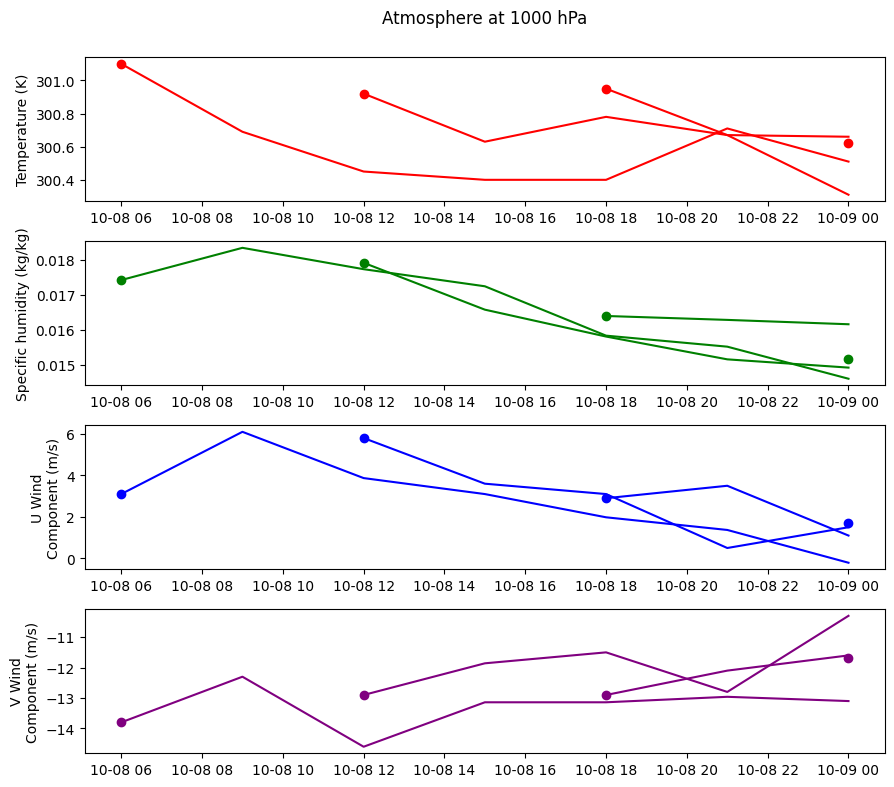

In [75]:
atmFig = plt.figure(figsize=(10,8))
tAx = atmFig.add_axes([0.1, 0.74, 0.8, 0.18])
qAx = atmFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = atmFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = atmFig.add_axes([0.1, 0.05, 0.8, 0.18])

atmLevel = 1000.0
for runTime, run in zip(atm.keys(), atm.values()):
  time = run.keys()
  t = [atm[runTime][timestep][atmLevel]["T"] for timestep in time]
  q = [atm[runTime][timestep][atmLevel]["q"] for timestep in time]
  u = [atm[runTime][timestep][atmLevel]["u"] for timestep in time]
  v = [atm[runTime][timestep][atmLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  qAx.plot(time, q, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["T"] for runTime in atm.keys()], color="red")
qAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["q"] for runTime in atm.keys()], color="green")
uAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["u"] for runTime in atm.keys()], color="blue")
vAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["v"] for runTime in atm.keys()], color="purple")

tAx.set_ylabel("Temperature (K)")
qAx.set_ylabel("Specific humidity (kg/kg)")
uAx.set_ylabel("U Wind\nComponent (m/s)")
vAx.set_ylabel("V Wind\nComponent (m/s)")

atmFig.suptitle(f"Atmosphere at {int(atmLevel)} hPa")
plt.savefig(f"atmParameters_{int(atmLevel)}hPa{figureSuffix}.png")
plt.show()

In [ ]:
windDir = {}
for runTime, run in zip(atm.keys(), atm.values()):
  windDir[runTime] = {}
  for time in run.keys():
    windDir[runTime][time] = np.arctan(atm[runTime][time][atmLevel]["u"] / atm[runTime][time][atmLevel]["v"]) * (180/np.pi) + 180

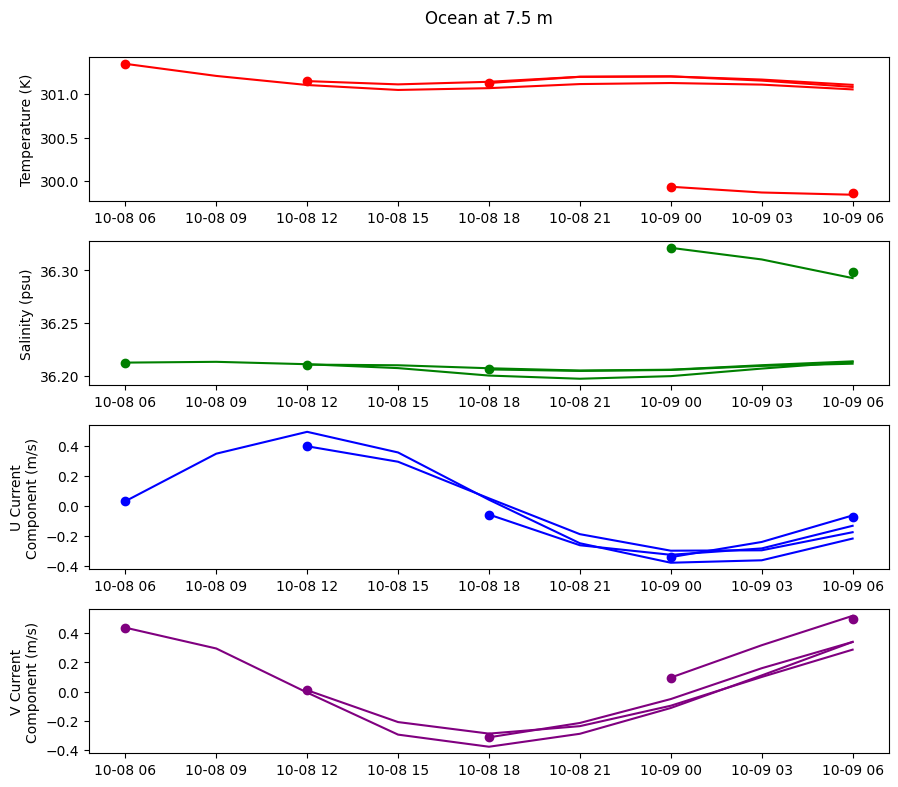

In [76]:
oceFig = plt.figure(figsize=(10,8))
tAx = oceFig.add_axes([0.1, 0.74, 0.8, 0.18])
sAx = oceFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = oceFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = oceFig.add_axes([0.1, 0.05, 0.8, 0.18])

oceLevel = 7.5
for runTime, run in zip(oce.keys(), oce.values()):
  time = run.keys()
  t = [oce[runTime][timestep][oceLevel]["T"] for timestep in time]
  s = [oce[runTime][timestep][oceLevel]["s"] for timestep in time]
  u = [oce[runTime][timestep][oceLevel]["u"] for timestep in time]
  v = [oce[runTime][timestep][oceLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  sAx.plot(time, s, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["T"] for runTime in oce.keys()], color="red")
sAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["s"] for runTime in oce.keys()], color="green")
uAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["u"] for runTime in oce.keys()], color="blue")
vAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["v"] for runTime in oce.keys()], color="purple")

tAx.set_ylabel("Temperature (K)")
sAx.set_ylabel("Salinity (psu)")
uAx.set_ylabel("U Current\nComponent (m/s)")
vAx.set_ylabel("V Current\nComponent (m/s)")

oceFig.suptitle(f"Ocean at {round(oceLevel,1)} m")
plt.savefig(f"oceParameters_{int(oceLevel)}m{figureSuffix}.png")
plt.show()

In [ ]:
currDir = {}
for runTime, run in zip(oce.keys(), oce.values()):
  currDir[runTime] = {}
  for time in run.keys():
    currDir[runTime][time] = np.arctan(oce[runTime][time][oceLevel]["u"] / oce[runTime][time][oceLevel]["v"]) * (180/np.pi) + 180

Text(0.5, 0, 'Time')

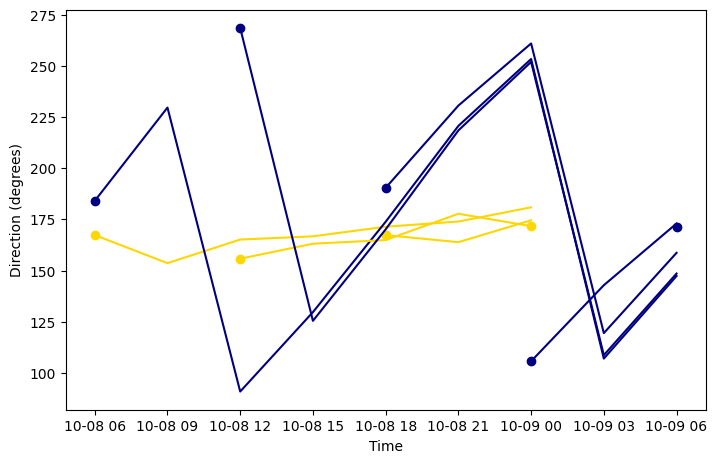

In [77]:
dirFig = plt.figure(figsize=(8,5))
dirAx = dirFig.add_axes([0.1, 0.1, 0.8, 0.8])

for runTime in windDir.keys():
  dirAx.plot(windDir[runTime].keys(), windDir[runTime].values(), color="gold")
  dirAx.plot(currDir[runTime].keys(), currDir[runTime].values(), color="navy")

dirAx.scatter(windDir.keys(), [windDir[runTime][runTime] for runTime in windDir.keys()], color="gold")
dirAx.scatter(currDir.keys(), [currDir[runTime][runTime] for runTime in currDir.keys()], color="navy")

dirAx.set_ylabel("Direction (degrees)")
dirAx.set_xlabel("Time")